In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aceus2807/weather-prediction-rnn-and-cnn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/weather-prediction-rnn-and-cnn


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import lag, col, lead
from pyspark.sql.window import Window
import os

In [ ]:
# Initialize SparkSession
spark = SparkSession.builder.appName("RainPredictionTuning").config("spark.memory.offHeap.enabled", "true").config("spark.memory.offHeap.size", "10g").getOrCreate()

In [ ]:
df = spark.read.csv(path + "/weather_dataset.csv", header=True, inferSchema=True)

In [ ]:
df.show(5)

+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+-----------+---------+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+----------+----------+------+---------+---+--------+--------+------------+--------------+
|location_name|country| lat|     lon|           tz_id|          localtime|      date|               time|temp_c|temp_f|is_day|condition_text|wind_mph|wind_kph|wind_degree|wind_dir|pressure_mb|pressure_in|precip_mm|precip_in|humidity|cloud|feelslike_c|feelslike_f|windchill_c|windchill_f|heatindex_c|heatindex_f|dewpoint_c|dewpoint_f|vis_km|vis_miles| uv|gust_mph|gust_kph|will_it_rain|chance_of_rain|
+-------------+-------+----+--------+----------------+-------------------+----------+-------------------+------+------+------+--------------+--------+--------+-----------+--------+-----------+------

In [ ]:
df = df.drop('country','lat','lon','date','tz_id','localtime','temp_f','wind_kph', 'feelslike_f','pressure_in','heatindex_f','precip_in','windchill_f', 'dewpoint_f','vis_miles','gust_kph','chance_of_rain')

In [ ]:
df.columns

['location_name',
 'time',
 'temp_c',
 'is_day',
 'condition_text',
 'wind_mph',
 'wind_degree',
 'wind_dir',
 'pressure_mb',
 'precip_mm',
 'humidity',
 'cloud',
 'feelslike_c',
 'windchill_c',
 'heatindex_c',
 'dewpoint_c',
 'vis_km',
 'uv',
 'gust_mph',
 'will_it_rain']

In [ ]:
# Index categorical columns
indexer = StringIndexer(inputCol='condition_text', outputCol='conditionid')
df = indexer.fit(df).transform(df)

In [ ]:
# Convert time to timestamp
df = df.withColumn("time", col("time").cast("timestamp"))

In [ ]:
# Create lagged features and target
window_spec = Window.partitionBy("location_name").orderBy("time")

# Keep only the current features (no lagging needed for current hour prediction)
current_features = ["precip_mm", "cloud", "dewpoint_c", "conditionid"]

# Create 24 target variables for the next 24 hours
for i in range(1, 25):
    df = df.withColumn(f"will_it_rain_hour_{i}", lead(col("will_it_rain"), i).over(window_spec))

# Select the current features and the 24 target variables
selected_cols = current_features + [f"will_it_rain_hour_{i}" for i in range(1, 25)]
df = df.select(selected_cols)

df = df.na.drop()

In [ ]:
df.show()

+---------+-----+----------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|precip_mm|cloud|dewpoint_c|conditionid|will_it_rain_hour_1|will_it_rain_hour_2|will_it_rain_hour_3|will_it_rain_hour_4|will_it_rain_hour_5|will_it_rain_hour_6|will_it_rain_hour_7|will_it_rain_hour_8|will_it_rain_hour_9|will_it_rain_hour_10|will_it_rain_hour_11|will_it_rain_hour_12|will_it_rain_hour_13|will_it_rain_hour_14|will_it_rain_hour_15|will_it_rain_hour_16|will_it_rain_hour_17|will_it_rain_hour_18|will_it_rain_hour_19|will_it_rain_hour_20|will_it_rain_

In [ ]:
# prompt: Tạo cho tôi 1 cột columns là will_it_rain_24h. Nếu các giá trị của will_it_rain_hour_1 cho đến will_it_rain_hour_24 tồn tại 1 thì will_it_rain_24h là 1. Ngược lại will_it_rain_24h là 0

df = df.withColumn("will_it_rain_24h",
  (sum([col(f"will_it_rain_hour_{i}") for i in range(1, 25)]) > 0).cast("integer"))

df.show()

+---------+-----+----------+-----------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------+
|precip_mm|cloud|dewpoint_c|conditionid|will_it_rain_hour_1|will_it_rain_hour_2|will_it_rain_hour_3|will_it_rain_hour_4|will_it_rain_hour_5|will_it_rain_hour_6|will_it_rain_hour_7|will_it_rain_hour_8|will_it_rain_hour_9|will_it_rain_hour_10|will_it_rain_hour_11|will_it_rain_hour_12|will_it_rain_hour_13|will_it_rain_hour_14|will_it_rain_hour_15|will_it_rain_hour_16|will_it_rain_hour_17|will_it_rain_hour_18|will_it_rain_hour_19|will_it_rain_hour

In [ ]:
indexer = StringIndexer(inputCol='will_it_rain_24h', outputCol='label')
df = indexer.fit(df).transform(df)

In [ ]:
# Assemble features
feature_columns = ["precip_mm", "cloud", "dewpoint_c", "conditionid"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df).select("features", "will_it_rain_24h")

In [ ]:
df.show()

+-------------------+----------------+
|           features|will_it_rain_24h|
+-------------------+----------------+
|[0.0,51.0,23.6,0.0]|               0|
|[0.0,65.0,23.7,2.0]|               0|
|[0.0,64.0,23.8,2.0]|               0|
|[0.0,51.0,23.9,0.0]|               0|
|[0.0,87.0,23.9,3.0]|               0|
|[0.0,83.0,24.0,2.0]|               0|
|[0.0,30.0,24.1,0.0]|               0|
|[0.0,25.0,24.0,5.0]|               0|
|[0.0,55.0,23.0,0.0]|               1|
|[0.0,42.0,21.8,0.0]|               1|
|[0.0,23.0,20.9,5.0]|               1|
|[0.0,44.0,21.8,0.0]|               1|
|[0.0,29.0,21.4,0.0]|               1|
|[0.0,71.0,19.3,2.0]|               1|
|[0.0,78.0,19.6,2.0]|               1|
|[0.0,86.0,20.1,3.0]|               1|
|[0.0,46.0,20.7,0.0]|               1|
|[0.0,80.0,21.1,2.0]|               1|
|[0.0,87.0,22.0,3.0]|               1|
|[0.0,22.0,22.4,4.0]|               1|
+-------------------+----------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)

In [ ]:
df = scaler_model.transform(df)

In [ ]:
# Define the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="will_it_rain_24h",
    predictionCol="prediction",
    metricName="accuracy"
)

In [ ]:
# Split the data into training and test sets
# Chia bộ dữ liệu thành hai phần: dữ liệu huấn luyện và dữ liệu kiểm thử.
train_data, validation_data ,test_data = df.randomSplit([0.7, 0.2, 0.1], seed = 42)

In [ ]:
print(f"Train set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")

Train set size: 387142
Test set size: 55769


In [ ]:
# Initialize classifiers
# Khởi tạo hai mô hình phân loại: Random Forest và Logistic Regression.
# rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=20, maxDepth=3)
# lr = LogisticRegression(labelCol='label', featuresCol='features', regParam=0.1, elasticNetParam=0.1)
rf = RandomForestClassifier(labelCol='will_it_rain_24h', featuresCol='scaled_features')
lr = LogisticRegression(labelCol='will_it_rain_24h', featuresCol='scaled_features', regParam=0.01, elasticNetParam=0.01)
svm = LinearSVC(labelCol='will_it_rain_24h', featuresCol='scaled_features')

In [ ]:
# Initialize pipeline
# Xây dựng pipeline cho mỗi mô hình để huấn luyện trên dữ liệu.
pipeline_rf = Pipeline(stages=[rf])
pipeline_lr = Pipeline(stages=[lr])
pipeline_svm = Pipeline(stages=[svm])

In [ ]:
# Fit the models
# Huấn luyện 2 mô hình
model_rf = pipeline_rf.fit(train_data)

In [ ]:
model_lr = pipeline_lr.fit(train_data)

In [ ]:
model_svm = pipeline_svm.fit(train_data)

In [ ]:
# Make predictions
# Dự đoán trên một tập test
predictions_rf = model_rf.transform(test_data)
predictions_lr = model_lr.transform(test_data)
predictions_svm = model_svm.transform(test_data)

In [ ]:
# Evaluate the models
# Đánh giá độ chính xác của hai mô hình
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_svm = evaluator.evaluate(predictions_svm)

In [ ]:
# Print the results
print('Random Forest Accuracy:', accuracy_rf)
print('Logistic Regression Accuracy:', accuracy_lr)
print('Support Vector Machine Accuracy:', accuracy_svm)

Random Forest Accuracy: 0.8346213846402123
Logistic Regression Accuracy: 0.8267496279294949
Support Vector Machine Accuracy: 0.8248847926267281


In [ ]:
# Calculate precision, recall, f1-score
# Tính toán các chỉ số precision, recall, và f1-score cho hai mô hình
evaluator.setMetricName('weightedPrecision')
precision_rf = evaluator.evaluate(predictions_rf)
precision_lr = evaluator.evaluate(predictions_lr)
precision_svm = evaluator.evaluate(predictions_svm)

evaluator.setMetricName('weightedRecall')
recall_rf = evaluator.evaluate(predictions_rf)
recall_lr = evaluator.evaluate(predictions_lr)
recall_svm = evaluator.evaluate(predictions_svm)

evaluator.setMetricName('f1')
f1_score_rf = evaluator.evaluate(predictions_rf)
f1_score_lr = evaluator.evaluate(predictions_lr)
f1_score_svm = evaluator.evaluate(predictions_svm)

In [ ]:
# Print the evaluation metrics
print('Random Forest Precision:', precision_rf)
print('Random Forest Recall:', recall_rf)
print('Random Forest F1-Score:', f1_score_rf)
print('Logistic Regression Precision:', precision_lr)
print('Logistic Regression Recall:', recall_lr)
print('Logistic Regressio F1-Score:', f1_score_lr)
print('Support Vector Machine Precision:', precision_svm)
print('Support Vector Machine Recall:', recall_svm)
print('Support Vector Machine F1-Score:', f1_score_svm)

Random Forest Precision: 0.8281018548885788
Random Forest Recall: 0.8346213846402123
Random Forest F1-Score: 0.8276108289457744
Logistic Regression Precision: 0.8206749627440333
Logistic Regression Recall: 0.8267496279294948
Logistic Regressio F1-Score: 0.813857609065902
Support Vector Machine Precision: 0.8181849611983711
Support Vector Machine Recall: 0.8248847926267281
Support Vector Machine F1-Score: 0.8122739579137598


In [ ]:
# from pyspark.sql import SparkSession
# import pandas as pd
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.sql.functions import col, expr, pow, sqrt, avg, abs

# # Assuming you have already defined model_rf and model_lr

# # Make predictions
# predictions_rf = model_rf.transform(test_data)
# predictions_lr = model_lr.transform(test_data)
# predictions_svm = model_svm.transform(test_data)

# # Calculate the absolute errors
# predictions_rf = predictions_rf.withColumn("absolute_error", abs(col("prediction") - col("will_it_rain_24h")))
# predictions_lr = predictions_lr.withColumn("absolute_error", abs(col("prediction") - col("will_it_rain_24h")))
# predictions_svm = predictions_svm.withColumn("absolute_error", abs(col("prediction") - col("will_it_rain_24h")))

# # Calculate Mean Absolute Error (MAE)
# mae_rf = predictions_rf.select(avg("absolute_error")).first()[0]
# mae_lr = predictions_lr.select(avg("absolute_error")).first()[0]
# mae_svm = predictions_svm.select(avg("absolute_error")).first()[0]

# # Calculate Median Absolute Error (MedAE)
# medae_rf = predictions_rf.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']
# medae_lr = predictions_lr.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']
# medae_svm = predictions_svm.select(expr('percentile(absolute_error, 0.5)').alias('medae')).first()['medae']

# # Calculate Relative Absolute Error (RAE)
# mean_label = predictions_rf.agg(avg(col("will_it_rain_24h"))).first()[0]
# rae_rf = predictions_rf.agg(avg(col("absolute_error") / mean_label)).first()[0]
# rae_lr = predictions_lr.agg(avg(col("absolute_error") / mean_label)).first()[0]
# rae_svm = predictions_svm.agg(avg(col("absolute_error") / mean_label)).first()[0]

# # Calculate Root Mean Square Error (RMSE)
# rmse_rf = predictions_rf.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]
# rmse_lr = predictions_lr.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]
# rmse_svm = predictions_svm.agg(sqrt(avg(pow(col("absolute_error"), 2)))).first()[0]

# # Calculate R-squared (R²)
# evaluator = RegressionEvaluator(labelCol="will_it_rain_24h", predictionCol="prediction", metricName="r2")
# r2_rf = evaluator.evaluate(predictions_rf)
# r2_lr = evaluator.evaluate(predictions_lr)
# r2_svm = evaluator.evaluate(predictions_svm)

# # Convert results to Pandas DataFrame for better visualization
# results_data = {
#     'Metric': ['MAE', 'MedAE', 'RAE', 'RMSE', 'R²'],
#     'Random Forest': [mae_rf, medae_rf, rae_rf, rmse_rf, r2_rf],
#     'Logistic Regression': [mae_lr, medae_lr, rae_lr, rmse_lr, r2_lr],
#     'Support Vector Machine': [mae_svm, medae_svm, rae_svm, rmse_svm, r2_svm]
# }

# results_df = pd.DataFrame(results_data)

# # Print the Pandas DataFrame
# print(results_df)

  Metric  Random Forest  Logistic Regression  Support Vector Machine
0    MAE       0.165379             0.173250                0.175115
1  MedAE       0.000000             0.000000                0.000000
2    RAE       0.226431             0.237209                0.239762
3   RMSE       0.406668             0.416234                0.418468
4     R²       0.160215             0.120243                0.110773


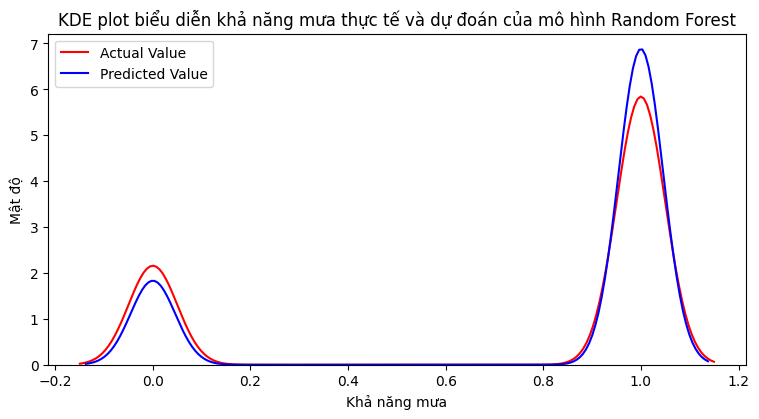

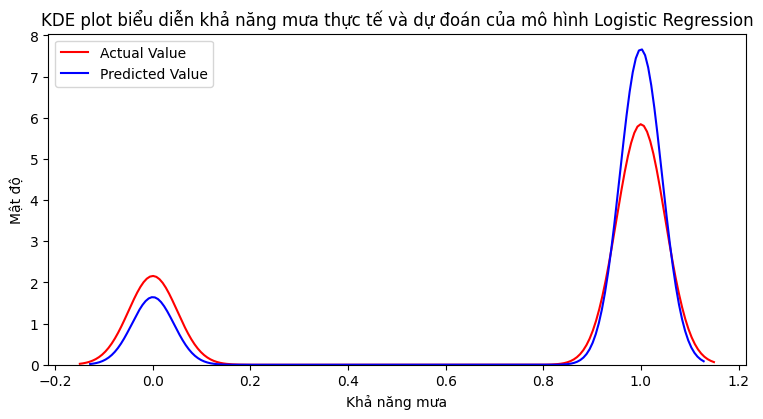

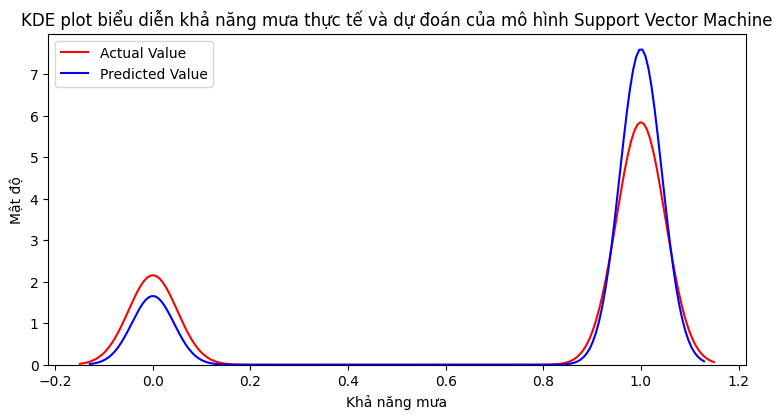

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Chuyển dữ liệu Spark DataFrame sang Pandas DataFrame
# # Giả định 'test_data' có cột 'label' chứa giá trị thực tế
# y_test_pd = test_data.select("will_it_rain_24h").toPandas()

# # Chuyển dữ liệu dự đoán sang Pandas DataFrame
# predictions_rf_pd = predictions_rf.select("prediction").toPandas()
# predictions_lr_pd = predictions_lr.select("prediction").toPandas()
# predictions_svm_pd = predictions_svm.select("prediction").toPandas()

# # Tạo từ điển với dữ liệu dự đoán
# predictions_dict = {"Random Forest": predictions_rf_pd['prediction'],
#                     "Logistic Regression": predictions_lr_pd['prediction'],
#                    "Support Vector Machine": predictions_svm_pd['prediction']}

# # Vẽ biểu đồ
# for model, dataPred in predictions_dict.items():
#     fig, ax1 = plt.subplots(figsize=(9, 4.3))

#     ax1 = sns.kdeplot(y_test_pd['will_it_rain_24h'], fill=False, color='r', label="Actual Value")
#     sns.kdeplot(dataPred, fill=False, color='b', label="Predicted Value", ax=ax1)

#     ax1.set_title(f"KDE plot biểu diễn khả năng mưa thực tế và dự đoán của mô hình {model}")

#     plt.xlabel('Khả năng mưa')
#     plt.ylabel('Mật độ')
#     plt.legend()
#     plt.show()

In [ ]:
# prompt: Kết nối với google drive cho tôi với.

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: Xuất ra file indexer và file 3 model cho tôi với

import os

# Define the directory where you want to save the files
output_dir = "/content/drive/My Drive/SparkModels"
os.makedirs(output_dir, exist_ok=True)

# Save the indexer
indexer_path = os.path.join(output_dir, "condition_text_indexer")
indexer.save(indexer_path)
print(f"StringIndexer model saved to: {indexer_path}")

# Save the Random Forest model
rf_model_path = os.path.join(output_dir, "random_forest_model")
model_rf.save(rf_model_path)
print(f"Random Forest model saved to: {rf_model_path}")

# Save the Logistic Regression model
lr_model_path = os.path.join(output_dir, "logistic_regression_model")
model_lr.save(lr_model_path)
print(f"Logistic Regression model saved to: {lr_model_path}")

# Save the Linear SVM model
svm_model_path = os.path.join(output_dir, "linear_svm_model")
model_svm.save(svm_model_path)
print(f"Linear SVM model saved to: {svm_model_path}")

StringIndexer model saved to: /content/drive/My Drive/SparkModels/condition_text_indexer
Random Forest model saved to: /content/drive/My Drive/SparkModels/random_forest_model
Logistic Regression model saved to: /content/drive/My Drive/SparkModels/logistic_regression_model
Linear SVM model saved to: /content/drive/My Drive/SparkModels/linear_svm_model
